In [29]:
# dependencies

import numpy as np
import pandas as pd

import xfx.mvglm.multinomial
import xfx.misc.plot

In [30]:
# helper functions

def package_samples(samples, factor_names, response_names):

    rfx_samples, prec_samples = zip(*samples)
    rfx_samples = [np.array(samples_) for samples_ in zip(*rfx_samples)]
    prec_samples = np.trace(prec_samples, axis1=2, axis2=3)
    return package_rfx_samples(rfx_samples, ['_const'] + factor_names, response_names), package_prec_samples(prec_samples, factor_names)

def package_rfx_samples(rfx_samples, factor_names, response_names):

    dfs = []
    for i, (samples_, factor_name) in enumerate(zip(rfx_samples, factor_names)):
        for j in range(samples_.shape[1]):
            df_ = pd.DataFrame(samples_[:, j].T, index=response_names)
            df_.index = df_.index.rename('response')
            df_.columns = df_.columns.rename('iter')
            df_['factor'] = factor_name
            df_['level'] = j
            dfs.append(df_)
    df = pd.concat(dfs).reset_index().set_index(['factor', 'level', 'response'])
    return df

def package_prec_samples(prec_samples, factor_names):

    df = pd.DataFrame(prec_samples.T, index=factor_names)
    df.index = df.index.rename('factor')
    df.columns = df.columns.rename('iter')
    return df

In [31]:
# select predictors and responses

factor_names = ['province_id', 'activity', 'age', 'education', 'municipality_size', 'voting_recall', 'gender']
response_names = ['conservatives', 'social_democrats']
exclude = ['abstention', 'invalid']

In [32]:
# configure algorithm (hyperprior on the random effect prior precision is Wishart(prior_pseudo_tau, prior_guess_tau / prior_pseudo_tau))

n_samples = 1000
n_warmup = 1000
prior_pseudo_tau = len(response_names) * np.ones(len(factor_names))
prior_guess_tau = len(factor_names) * [np.identity(len(response_names))]
seed = 0

In [33]:
# create inputs

cis = pd.read_csv('demos/data/cis.csv')
cis = cis.loc[(cis.study_id == '2019-11-10') & (~cis.voting_intention.isin(exclude)) & (~cis.voting_intention.isna())]
cis['response'] = np.where(cis.voting_intention.isin(response_names), cis.voting_intention, '_others')
cis['voting_recall'] = np.where(cis.voting_recall.isin(response_names), cis.voting_recall, '_others')
cis = cis[factor_names + ['response']].dropna()
codes = cis.apply(lambda x: x.astype('category').cat.codes)
n_true = pd.get_dummies(codes.response)
indices = codes.drop('response', 1)
n_levels = np.max(indices, 0).astype(np.int64) + 1
rng = np.random.default_rng(seed)

In [34]:
# sample

sampler = xfx.mvglm.multinomial.sample_posterior(n_true.values, n_levels, indices.values, prior_n_tau=prior_pseudo_tau, prior_est_tau=prior_guess_tau, ome=rng)
samples = [next(sampler) for _ in range(n_samples + n_warmup)][n_warmup:]

In [35]:
# reformat samples for plotting

rfx_samples, prec_samples = package_samples(samples, factor_names, response_names)

In [36]:
# random effects samples

rfx_samples.iloc[:5, :5]

iter                                       0         1         2         3  \
factor      level response                                                   
_const      0     conservatives     0.846028 -0.087659  0.591251 -1.434905   
                  social_democrats -0.097628 -0.633179 -0.361038 -0.366271   
province_id 0     conservatives     0.524317  0.900155  0.834993  1.008892   
                  social_democrats -0.528491 -0.001726 -0.011608  0.133985   
            1     conservatives    -0.068354 -0.122401 -0.134152  0.039748   

iter                                       4  
factor      level response                    
_const      0     conservatives     0.225482  
                  social_democrats -1.923521  
province_id 0     conservatives     1.082843  
                  social_democrats  0.019384  
            1     conservatives     0.113699

In [37]:
# prior precision trace samples

prec_samples.iloc[:5, :5]

iter,0,1,2,3,4
factor,,,,,
province_id,9.371331,7.840570,9.225286,9.631262,11.674049
activity,6.695500,7.878779,3.336218,3.955409,1.876728
age,1.714593,4.580943,2.425293,3.450174,4.151870
education,1.546513,6.217430,2.084062,2.466395,1.922860
municipality_size,4.952027,3.876159,4.569271,4.332509,5.112942


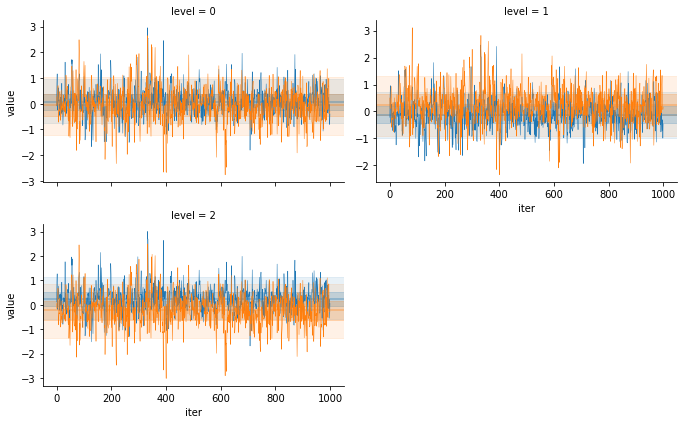

In [38]:
# plot traces for 'voting_recall' random effects, grid by level, color by level

xfx.misc.plot.plot_traces(rfx_samples.loc['age'], 'iter', 'level', 'response')

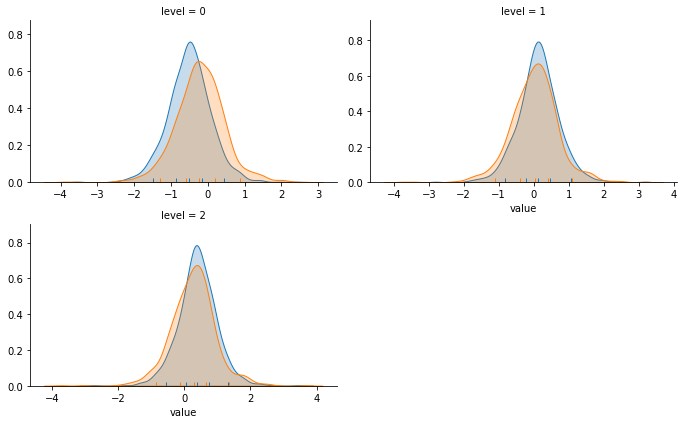

In [39]:
# plot marginals for 'age' random effects, grid by level, color by response

xfx.misc.plot.plot_marginals(rfx_samples.loc['education'], 'level', 'response')

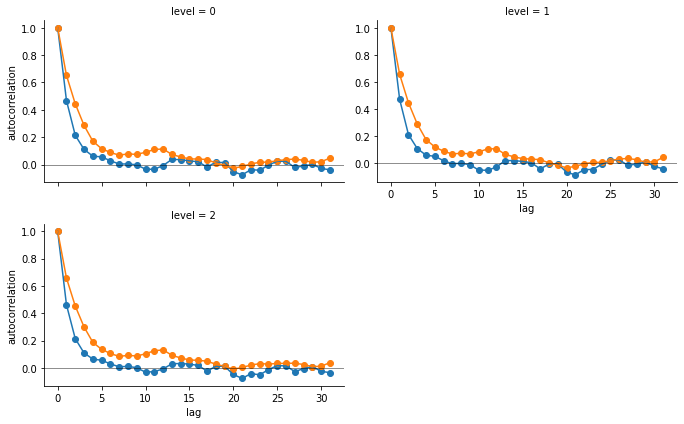

In [40]:
# plot ACFs for prior precisions, grid by level, color by response

xfx.misc.plot.plot_acf(rfx_samples.loc['voting_recall'], 'level', 'response')